В домашней работе необходимо с помощью AutoKeras или KerasTuner найти оптимальную модель для решения одной из следующей задач:

1. На 3 балла. Обучите модель с точностью не менее 90% предсказывать сарказм в новостных заголовках. Составьте 5 произвольных заголовков, которых нет в датасете и проверьте на них обученную модель, сделайте выводы. Ссылка на [датасет](https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip).
2. На 4 балла. Используйте [русский корпус новостей от Lenta.ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/data) подберите и обучите модель классифицировать новости по заголовкам на классы (поле topic в датасете). Используйте 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов. Оцените модель с помощью отчета о классификации, сделайте выводы.  
3. На 5 баллов. Найдите публичный датасет по обращениям граждан в администрацию, техническую поддержку или за консультацией. Обучите модель классифицировать обращения по тематикам. Сформируйте отчет о классификации и матрицу ошибок.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip
!unzip -qo "Sarcasm_Headlines_Dataset_v2.json.zip" -d ./dataset

In [ ]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

In [ ]:
import numpy as np
import pandas as pd
import re
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
address = "./dataset/Sarcasm_Headlines_Dataset_v2.json"
json_df = pd.read_json(address, lines=True)
df_sarcasm = pd.DataFrame(json_df)
df_sarcasm = df_sarcasm.drop("article_link", axis=1)

In [ ]:
print(df_sarcasm.head())

   is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails why congress is falling...
2             0  eat your veggies: 9 deliciously different recipes
3             1  inclement weather prevents liar from getting t...
4             1  mother comes pretty close to using word 'strea...


In [ ]:
print('Найдено дубликатов: ', df_sarcasm.duplicated().sum())
# Удаляем дубликаты
df_sarcasm.drop_duplicates(subset=['headline'], inplace=True)
print('Осталось дубликатов после очистки: ', df_sarcasm.duplicated().sum())

Найдено дубликатов:  116
Осталось дубликатов после очистки:  0


In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df_sarcasm.headline),
                                                  np.array(df_sarcasm.is_sarcastic), test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [ ]:
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[0])

Форма входных данных:  (19952,)
Форма выходных меток:  (19952,)
Пример заголовка:  lizard planning to bite new owner first chance it gets


In [ ]:
del df_sarcasm, X_tmp, y_tmp

In [ ]:
# Создание ансамбля моделей (3 наиболее подходящие к данным моделей)
clf = ak.TextClassifier(overwrite=True, max_trials=3, objective='val_accuracy')

# Обучаем 2 модели на 4-х эпохах, размер пакета подбирается автоматически
result_training = clf.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Trial 3 Complete [01h 29m 20s]
val_accuracy: 0.9057310223579407

Best val_accuracy So Far: 0.9057310223579407
Total elapsed time: 01h 30m 42s
Epoch 1/2
Not enough memory, reduce batch size to 16.
Epoch 1/2
Not enough memory, reduce batch size to 8.
Epoch 1/2
2494/2494 [==============================] - 2553s 1s/step - loss: 0.2697 - accuracy: 0.8804 - val_loss: 0.2363 - val_accuracy: 0.9015
Epoch 2/2
2494/2494 [==============================] - 2538s 1s/step - loss: 0.1871 - accuracy: 0.9272 - val_loss: 0.2363 - val_accuracy: 0.9015


In [ ]:
def plot_graphs(history, key):
    # И
    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построениспользуем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12,6))
я графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()


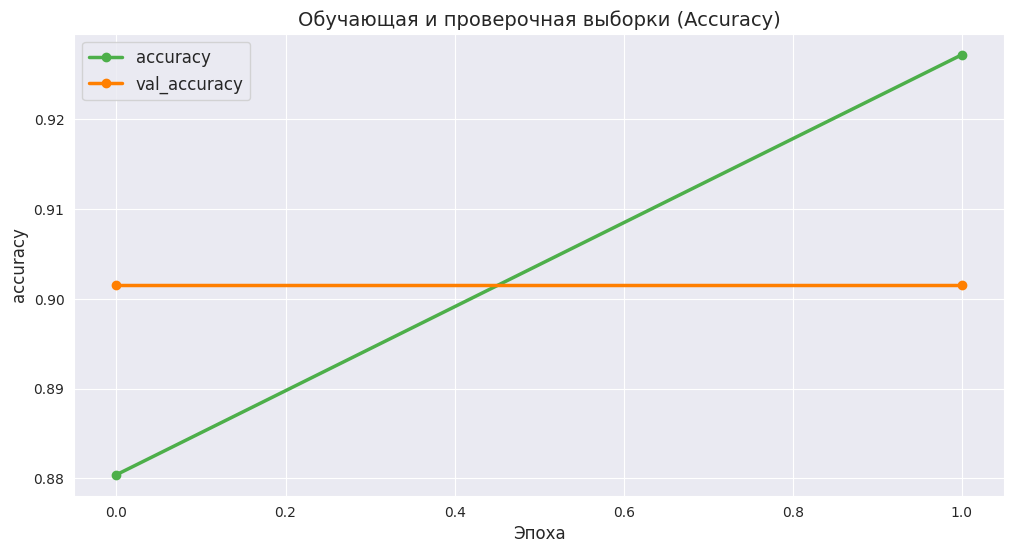

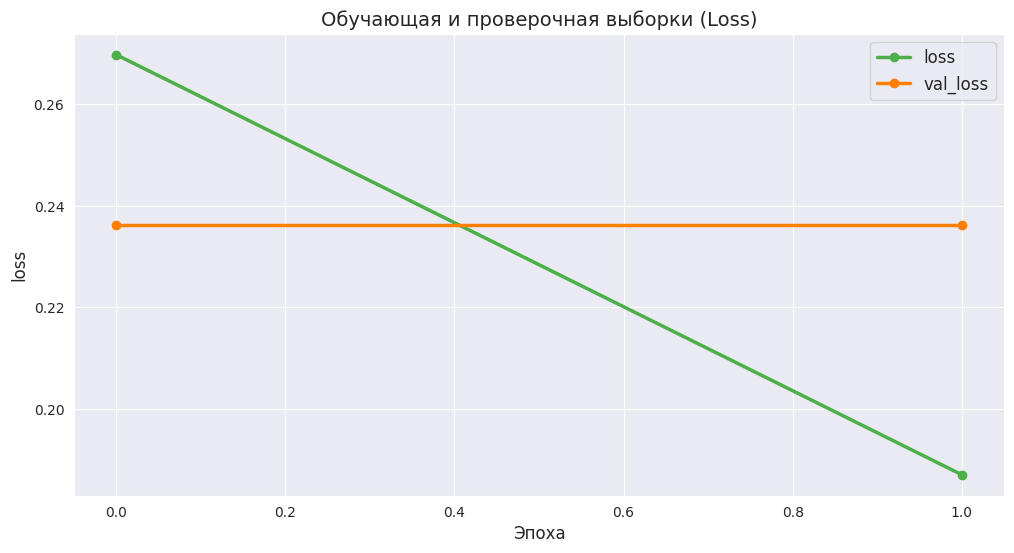

In [ ]:
# строим график точности
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

In [ ]:
# Последовательно экспортируем лучшую модель и по ней выводим отчет
print(clf.export_model().summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 expand_last_dim (ExpandLas  (None, 1)                    0         ['input_1[0][0]']             
 tDim)                                                                                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None,)                      0         ['expand_last_dim[0][0]']     
                                                                                                  
 bert_preprocessor (BertPre  {'token_ids': (None, 512),   0         ['tf.reshape[0][0]']      

In [ ]:
# Предсказание на лучшей модели
predicted_y = clf.predict(X_test)

134/134 [==============================] - 179s 1s/step


In [ ]:
# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

134/134 [==============================] - 185s 1s/step - loss: 0.2162 - accuracy: 0.9107
[0.2161835879087448, 0.9106642007827759]


In [ ]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2215
           1       0.92      0.89      0.91      2061

    accuracy                           0.91      4276
   macro avg       0.91      0.91      0.91      4276
weighted avg       0.91      0.91      0.91      4276



In [ ]:
# Определим функцию предсказания сарказма
def predict_sarcasm(text, model):
    # Предсказание
    result = model.predict(np.array([text]))
    if result[0] == 0:
        print("Предложение: '{}' не содержит сарказма.".format(text))
    elif result[0] == 1:
        print("Предложение : '{}' содержит сарказм.".format(text))

In [ ]:
# Произвольные фразы, в которых мы предполагаем наличие сарказма или его отсутствие
sarcasm = "You look like at your own funeral but pretty much worse"
predict_sarcasm(sarcasm, clf)

sarcasm = "I adore talking about nothing. It is only I can say something about"
predict_sarcasm(sarcasm, clf)

sarcasm = "Oh, have I touched that tiny ego of yours?"
predict_sarcasm(sarcasm, clf)

sarcasm = "You kind of look like a homeless man. That’s the style now, innit?"
predict_sarcasm(sarcasm, clf)

sarcasm = "I’m not your type. Not made of latex"
predict_sarcasm(sarcasm, clf)

without_sarcasm = "I love spending time with my family during the holidays."
predict_sarcasm(without_sarcasm, clf)

1/1 [==============================] - 0s 101ms/step
Предложение: 'You look like at your own funeral but pretty much worse' не содержит сарказма.
1/1 [==============================] - 0s 110ms/step
Предложение: 'I adore talking about nothing. It is only I can say something about' не содержит сарказма.
1/1 [==============================] - 0s 102ms/step
Предложение: 'Oh, have I touched that tiny ego of yours?' не содержит сарказма.


1/1 [==============================] - 0s 112ms/step
Предложение: 'You kind of look like a homeless man. That’s the style now, innit?' не содержит сарказма.


1/1 [==============================] - 0s 105ms/step
Предложение: 'I’m not your type. Not made of latex' не содержит сарказма.
1/1 [==============================] - 0s 108ms/step
Предложение: 'I love spending time with my family during the holidays.' не содержит сарказма.


**Все фразы с сарказмом не угадал** ☹ :)